<a href="https://colab.research.google.com/github/NidhiiParmar/Music-Recommendation/blob/main/Music.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import timedelta
from sklearn.impute import SimpleImputer
from pandas_profiling import ProfileReport
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import FormatStrFormatter

from lightgbm import LGBMClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, roc_curve

import sklearn.datasets
import sklearn.metrics
import optuna

In [ ]:
df_train = pd.read_csv('/content/train.csv')
df_train.head()

msno  \
0  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   
1  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
2  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
3  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
4  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   

                                        song_id source_system_tab  \
0  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=           explore   
1  bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=        my library   
2  JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=        my library   
3  2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=        my library   
4  3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=           explore   

    source_screen_name      source_type  target  
0              Explore  online-playlist     1.0  
1  Local playlist more   local-playlist     1.0  
2  Local playlist more   local-playlist     1.0  
3  Local playlist more   local-playlist     1.0  
4              Explore  online-playlist     1.0

In [ ]:
df_train.shape

(31173, 6)

In [ ]:
df_songs = pd.read_csv('/content/songs.csv')
df_songs.head()

song_id  song_length genre_ids  \
0  CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=       247640       465   
1  o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=       197328       444   
2  DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=       231781       465   
3  dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=       273554       465   
4  W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=       140329       726   

        artist_name                            composer     lyricist  language  
0  張信哲 (Jeff Chang)                                  董貞          何啟弘       3.0  
1         BLACKPINK  TEDDY|  FUTURE BOUNCE|  Bekuh BOOM        TEDDY      31.0  
2      SUPER JUNIOR                                 NaN          NaN      31.0  
3             S.H.E                                 湯小康          徐世珍       3.0  
4              貴族精選                         Traditional  Traditional      52.0

In [ ]:
df_songs.shape

(84497, 7)

In [ ]:
# Merge datasets by the song_id column

df_full = pd.merge(left=df_train, right=df_songs, on='song_id', how='left')
df_full.head(3)

msno  \
0  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   
1  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
2  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   

                                        song_id source_system_tab  \
0  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=           explore   
1  bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=        my library   
2  JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=        my library   

    source_screen_name      source_type  target  song_length genre_ids  \
0              Explore  online-playlist     1.0          NaN       NaN   
1  Local playlist more   local-playlist     1.0          NaN       NaN   
2  Local playlist more   local-playlist     1.0          NaN       NaN   

  artist_name composer lyricist  language  
0         NaN      NaN      NaN       NaN  
1         NaN      NaN      NaN       NaN  
2         NaN      NaN      NaN       NaN

In [ ]:
df_full.shape

(31173, 12)

In [ ]:
df_songs_extra = pd.read_csv('/content/song_extra_info.csv')
df_songs_extra.head()

song_id             name          isrc
0  LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=               我們  TWUM71200043
1  ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=  Let Me Love You  QMZSY1600015
2  u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=              原諒我  TWA530887303
3  92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=          Classic  USSM11301446
4  0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=             愛投羅網  TWA471306001

In [ ]:
df_full = pd.merge(left=df_full, right=df_songs_extra, on='song_id', how='left')
df_full.head(3)

msno  \
0  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   
1  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
2  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   

                                        song_id source_system_tab  \
0  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=           explore   
1  bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=        my library   
2  JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=        my library   

    source_screen_name      source_type  target  song_length genre_ids  \
0              Explore  online-playlist     1.0          NaN       NaN   
1  Local playlist more   local-playlist     1.0          NaN       NaN   
2  Local playlist more   local-playlist     1.0          NaN       NaN   

  artist_name composer lyricist  language name isrc  
0         NaN      NaN      NaN       NaN  NaN  NaN  
1         NaN      NaN      NaN       NaN  NaN  NaN  
2         NaN      NaN      NaN       NaN  NaN  NaN

In [ ]:
df_full.shape

(31173, 14)

In [ ]:
df_members = pd.read_csv('/content/members.csv')
df_members.head()

msno  city  bd gender  \
0  XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=     1   0    NaN   
1  UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=     1   0    NaN   
2  D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=     1   0    NaN   
3  mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=     1   0    NaN   
4  q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=     1   0    NaN   

   registered_via  registration_init_time  expiration_date  
0               7                20110820         20170920  
1               7                20150628         20170622  
2               4                20160411         20170712  
3               9                20150906         20150907  
4               4                20170126         20170613

In [ ]:
# Also check the dataset size

df_members.shape

(34403, 7)

In [ ]:
df_full = pd.merge(left=df_full, right=df_members, on='msno', how='left')
df_full.head(3)

msno  \
0  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   
1  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
2  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   

                                        song_id source_system_tab  \
0  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=           explore   
1  bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=        my library   
2  JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=        my library   

    source_screen_name      source_type  target  song_length genre_ids  \
0              Explore  online-playlist     1.0          NaN       NaN   
1  Local playlist more   local-playlist     1.0          NaN       NaN   
2  Local playlist more   local-playlist     1.0          NaN       NaN   

  artist_name composer lyricist  language name isrc  city  bd  gender  \
0         NaN      NaN      NaN       NaN  NaN  NaN     1   0     NaN   
1         NaN      NaN      NaN       NaN  NaN  NaN    13  24  female   
2         NaN      NaN      NaN       NaN  NaN  NaN    13  24  female   

   registered_via  registration_init_time  expiration_date  
0               7                20120102         20171005  
1               9                20110525         20170911  
2               9                20110525         20170911

In [ ]:
# Check the finally dataset size

df_full.shape

(31173, 20)

In [ ]:
# Use one of the AutoEDA tool - Pandas Profile Report from pandas_profiling libruary
# Function report output

profile = ProfileReport(df_full, title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Determining the number of completely filled objects, the percentage and the number of missing values in features:
# We will need this several times for EDA, so I will create two functions for this purpose

def print_useful_rows_info(df):
    print('Number of completely filled objects from the entire sample:', len(df.dropna()))
    print('Percent of completely filled objects from the entire sample:', round(len(df.dropna()) / len(df) * 100, 2))

def missing_values(df):
    n = 0
    missing_values = ((df.isna().sum() / len(df)) * 100).sort_values(ascending=False)
    for i in range(0, len(missing_values)):
        if missing_values[i] > 0:
            print(missing_values.index[i], '-', df.loc[:, missing_values.index[i]].isna().sum())
            n += 1
        if n == 0 and i == len(missing_values) - 1:
            print(n)

print_useful_rows_info(df_full)
perc_missing_values = ((df_full.isna().sum() / len(df_full)) * 100).sort_values(ascending=False)
print(f'Percent of missing values:\n' + f'{perc_missing_values}')

Number of completely filled objects from the entire sample: 1004
Percent of completely filled objects from the entire sample: 3.22
Percent of missing values:
lyricist                  81.378116
composer                  76.085074
genre_ids                 70.243480
song_length               69.781542
artist_name               69.781542
language                  69.781542
isrc                      66.256055
name                      63.028903
gender                    39.216630
source_screen_name         3.297726
source_system_tab          0.295127
source_type                0.208514
target                     0.003208
registration_init_time     0.000000
registered_via             0.000000
msno                       0.000000
bd                         0.000000
city                       0.000000
song_id                    0.000000
expiration_date            0.000000
dtype: float64


In [ ]:
print('Number of missing values in columns:')
missing_values(df_full)

Number of missing values in columns:
lyricist - 25368
composer - 23718
genre_ids - 21897
song_length - 21753
artist_name - 21753
language - 21753
isrc - 20654
name - 19648
gender - 12225
source_screen_name - 1028
source_system_tab - 92
source_type - 65
target - 1


In [ ]:
# Leave only filled rows for features with gaps less than 1%

df_full = df_full[(df_full.artist_name.notna()) & (df_full.source_system_tab.notna()) & (df_full.source_type.notna()) &
                 (df_full.name.notna()) & (df_full.language.notna())]

In [ ]:
# Check the number of missing values in columns

print('Number of missing values in columns:')
missing_values(df_full)

Number of missing values in columns:
gender - 1247
lyricist - 1170
composer - 651
isrc - 335
source_screen_name - 104
genre_ids - 61


In [ ]:
# Convert the data type of some numeric features to 'str', since they are actually categorical. For the model, for example,
# 20 > 15, but in fact it cannot be said that one city is better than another by 25%. This can degrade the predictive ability
# of the model.

df_full.genre_ids = df_full.genre_ids.astype('str')
df_full.registered_via = df_full.registered_via.astype('str')
df_full.city = df_full.city.astype('str')
df_full.language = df_full.language.astype('str')

In [ ]:
# Create a function to calculate the interquartile range

def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    return boundaries

Bottom border -  -45.0 
Upper border -  75.0 
Number of outliers -  1


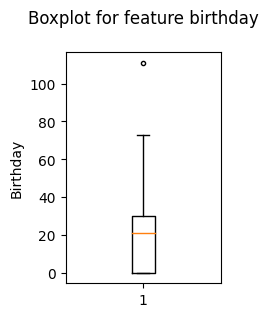

In [ ]:
# Define outliers with a function in feature 'birthday'(or 'bd') and vizualizate it

boundaries = calculate_outliers(df_full['bd'])
outlier = (df_full['bd'] < boundaries[0]) | (df_full['bd'] > boundaries[1])
print('Bottom border - ', boundaries[0], '\nUpper border - ', boundaries[1], '\nNumber of outliers - ', outlier.sum())

plt.figure(figsize=(2, 3))
plt.boxplot(df_full['bd'][df_full['bd'].notna()], sym='.')
plt.ylabel('Birthday')
plt.title('Boxplot for feature birthday' + '\n')
plt.show();

In [ ]:
# The values 150, 900, 1000 years are clearly outliers. Removing them from the dataset

df_full = df_full[df_full.bd < boundaries[1]]

In [ ]:
# Create a function to plot the distribution of feature values

def distribution_graph(data, feat, n_bins):
    fig, ax = plt.subplots(figsize=(5, 3))

    ax.hist(data.values, bins=n_bins, color=['blue'])
    ax.set_xlabel('Feature value ' + feat)
    ax.set_ylabel('Frequency')
    ax.set_title('Feature distribution ' + feat)
    fig.autofmt_xdate(rotation=45)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'));

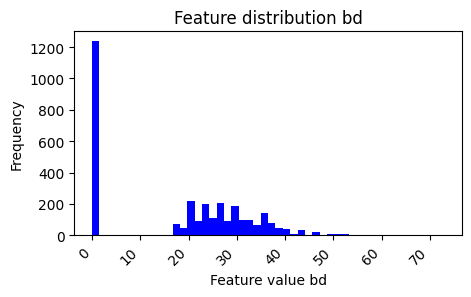

In [ ]:
# Displaying a distribution plot for feature 'bd'

distribution_graph(df_full.bd, 'bd', df_full['bd'].nunique())

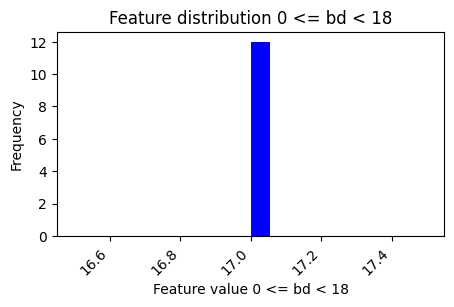

In [ ]:
#  ... and separately for age before 18

distribution_graph(df_full.bd[(df_full.bd < 18) & df_full.bd[(df_full.bd >= 0)]], '0 <= bd < 18', 18)

In [ ]:
# It is unlikely that children 4, 6 or 8 years old could create and use an account. In any case, there are not many such values.
# Also remove them from the dataset

df_full = df_full[df_full.bd >= 15]

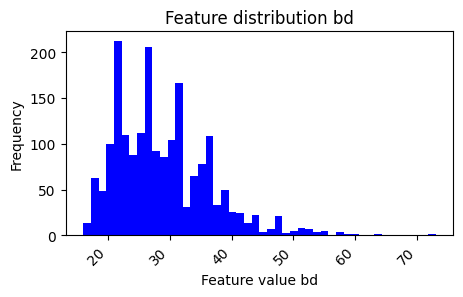

In [ ]:
distribution_graph(df_full.bd, 'bd', df_full['bd'].nunique())

In [ ]:
# Convert the registration_init_time and expiration date attributes to datetime and generate new attributes: day of the month,
# day of the week, month, year of registration start and end, and its duration in days

df_full.registration_init_time = df_full.registration_init_time.astype('str')
df_full.registration_init_time = df_full.registration_init_time.apply(lambda x: x[:4] + '-' + x[4:6] + '-' + x[6:8])
df_full.registration_init_time = pd.to_datetime(df_full.registration_init_time)
df_full['r_month'] = df_full.registration_init_time.dt.month
df_full['r_dayofweek'] = df_full.registration_init_time.dt.weekday
df_full['r_year'] = df_full.registration_init_time.dt.year
df_full['r_day'] = df_full.registration_init_time.dt.day

df_full.expiration_date = df_full.expiration_date.astype('str')
df_full.expiration_date = df_full.expiration_date.apply(lambda x: x[:4] + '-' + x[4:6] + '-' + x[6:8])
df_full.expiration_date = pd.to_datetime(df_full.expiration_date)
df_full['e_month'] = df_full.expiration_date.dt.month
df_full['e_dayofweek'] = df_full.expiration_date.dt.weekday
df_full['e_year'] = df_full.expiration_date.dt.year
df_full['e_day'] = df_full.expiration_date.dt.day

df_full['re_delta'] = df_full.apply(lambda x: (x.expiration_date - x.registration_init_time).days, axis=1)

df_full = df_full.drop(columns=['expiration_date', 'registration_init_time'])
df_full.head()

msno  \
10   uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=   
95   Eaq21N7ijazDjnqU5v1jjWewJopGxgZxkKr4GIq7JTs=   
96   pNPe9+kUnGJem0nHfYPdQ/Jx5yNlGLTJLshSohjkSdA=   
110  LxfIvtDj+f+3XFreJe9FET/osOASyHevAyuO+BzgjeU=   
164  PQfNQQon0CwOLghOAyztQYVw6yJTVgmFpJ650q/UF1s=   

                                          song_id source_system_tab  \
10   t0aT90DlS1TGncgnKoL0SvfAWEr3Dl72QBVcokmKfLc=        my library   
95   BwDDym6Tp7EnGudWBGJyjONZeX0/4ndu5PETiPWzav8=        my library   
96   b+OlR6qF0gzG++m+sYrOnf7bJF6WmXv51xGLBpmugxg=        my library   
110  jRgAVTjQ9GHuBdQ48SOlLVD0xf16DODOslUaq4NGQ2Y=        my library   
164  Pi/UFGfdwTNL16GM/+2JRttGTs2Nk4iZTehyMTfGibQ=          discover   

      source_screen_name          source_type  target  song_length genre_ids  \
10   Local playlist more        local-library     1.0     223933.0       465   
95                   NaN        local-library     1.0     333024.0       458   
96   Local playlist more        local-library     1.0     288391.0       458   
110  Local playlist more        local-library     1.0     316162.0       465   
164                  NaN  top-hits-for-artist     1.0     275121.0       465   

           artist_name                               composer  ...  \
10    Lindsey Stirling  Lindsey Stirling| Dia Frampton| SILAS  ...   
95   楊乃文 (Naiwen Yang)                                    黃建為  ...   
96    陳奕迅 (Eason Chan)                            Jun Jie Lin  ...   
110   陳奕迅 (Eason Chan)                            Hai Ying Li  ...   
164      李聖傑 (Sam Lee)                                     陳熙  ...   

    registered_via r_month r_dayofweek r_year r_day  e_month e_dayofweek  \
10               9      11           0   2011     7        3           6   
95               9       9           4   2010     3       10           0   
96               9       9           3   2010    16        9           5   
110              9      11           4   2014     7        9           6   
164              3      11           6   2014     2        6           5   

    e_year  e_day  re_delta  
10    2018      4      2309  
95    2017     23      2607  
96    2017     30      2571  
110   2017     10      1038  
164   2017     17       958  

[5 rows x 27 columns]

In [ ]:
# Transform categorical variables with TargetEncoder

data = ['msno', 'song_id', 'source_type', 'genre_ids', 'artist_name', 'composer',
        'lyricist', 'name', 'city', 'gender', 'registered_via', 'language']
encoder = TargetEncoder(smoothing=0.5)
for elem in data:
     df_full[elem+'_encoding'] = encoder.fit_transform(df_full[elem], df_full['target'])

In [ ]:
# Normalization of numeric variables with StandardScaler

quant_list = ['song_length', 'bd', 'r_month', 'r_dayofweek', 'r_day', 'e_month', 'e_dayofweek', 'e_year', 'e_day',
              're_delta']
data_quant = df_full[quant_list]
std_scaler = StandardScaler()
std_scaler.fit(data_quant)
std_scaled = std_scaler.transform(data_quant)
std_quant_list = ['std_scaled_' + elem for elem in quant_list]
df_full[std_quant_list] = std_scaled

In [ ]:
# Remove non-informative columns and original features before transformations

columns_for_drop = ['msno', 'song_id', 'source_system_tab', 'source_screen_name', 'source_type', 'genre_ids', 'artist_name',
                    'composer', 'lyricist', 'name', 'isrc', 'city', 'gender', 'registered_via', 'language', 'song_length',
                    'bd', 'r_year', 'r_month', 'r_dayofweek', 'r_day', 'e_month', 'e_dayofweek', 'e_year', 'e_day', 're_delta']
df_prepared = df_full.drop(columns=columns_for_drop)
df_prepared.head()

target  msno_encoding  song_id_encoding  source_type_encoding  \
10      1.0       0.776679          0.776679              0.854260   
95      1.0       0.776679          0.776691              0.854260   
96      1.0       0.776679          0.776679              0.854260   
110     1.0       0.776679          0.776679              0.854260   
164     1.0       0.776679          0.776679              0.507692   

     genre_ids_encoding  artist_name_encoding  composer_encoding  \
10             0.781765              0.776679           0.776679   
95             0.770718              0.776699           0.776649   
96             0.770718              0.817435           0.776679   
110            0.781765              0.817435           0.776679   
164            0.781765              0.776679           0.776679   

     lyricist_encoding  name_encoding  city_encoding  ...  \
10            0.742112       0.776679       0.791667  ...   
95            0.750009       0.776691       0.735849  ...   
96            0.742112       0.776679       0.750000  ...   
110           0.742112       0.776679       0.735849  ...   
164           0.776679       0.776679       0.725926  ...   

     std_scaled_song_length  std_scaled_bd  std_scaled_r_month  \
10                -0.536913      -0.367825            1.154704   
95                 1.831276      -0.239003            0.583448   
96                 0.862366       2.208628            0.583448   
110                1.465229      -0.239003            1.154704   
164                0.574296      -1.011939            1.154704   

     std_scaled_r_dayofweek  std_scaled_r_day  std_scaled_e_month  \
10                -1.565066         -0.948900           -2.142138   
95                 0.509092         -1.409736            0.627605   
96                -0.009448          0.087981            0.231928   
110                0.509092         -0.948900            0.231928   
164                1.546171         -1.524945           -0.955105   

     std_scaled_e_dayofweek  std_scaled_e_year  std_scaled_e_day  \
10                 1.343969           2.246447         -1.313411   
95                -1.617902          -0.328389          0.706825   
96                 0.850323          -0.328389          1.451123   
110                1.343969          -0.328389         -0.675442   
164                0.850323          -0.328389          0.068856   

     std_scaled_re_delta  
10              0.208337  
95              0.467388  
96              0.436094  
110            -0.896546  
164            -0.966090  

[5 rows x 23 columns]

In [ ]:
# Check and visualizate the correlation of final features

df_prepared.corr()

target  msno_encoding  song_id_encoding  \
target                   1.000000       0.024585          0.075926   
msno_encoding            0.024585       1.000000         -0.032243   
song_id_encoding         0.075926      -0.032243          1.000000   
source_type_encoding     0.351962       0.075780          0.003694   
genre_ids_encoding       0.049850       0.051585          0.070635   
artist_name_encoding     0.143444       0.009131          0.507058   
composer_encoding        0.105840      -0.075730          0.687348   
lyricist_encoding        0.107910      -0.056422          0.374050   
name_encoding            0.077979      -0.033608          0.990501   
city_encoding            0.111254       0.061180          0.003279   
gender_encoding          0.058512      -0.040404          0.015137   
registered_via_encoding  0.034034       0.156881          0.002687   
language_encoding        0.024521       0.083550         -0.076551   
std_scaled_song_length   0.015442      -0.050941          0.111862   
std_scaled_bd           -0.031573       0.101234         -0.032756   
std_scaled_r_month       0.015240      -0.124463          0.034521   
std_scaled_r_dayofweek   0.002473      -0.000976          0.017953   
std_scaled_r_day         0.017912       0.047638         -0.000738   
std_scaled_e_month       0.011148       0.156095          0.004316   
std_scaled_e_dayofweek  -0.033301       0.147847         -0.006977   
std_scaled_e_year        0.092411      -0.036011          0.011183   
std_scaled_e_day         0.003082       0.171538         -0.034910   
std_scaled_re_delta      0.015006      -0.100661          0.022920   

                         source_type_encoding  genre_ids_encoding  \
target                               0.351962            0.049850   
msno_encoding                        0.075780            0.051585   
song_id_encoding                     0.003694            0.070635   
source_type_encoding                 1.000000            0.064435   
genre_ids_encoding                   0.064435            1.000000   
artist_name_encoding                 0.080376            0.112764   
composer_encoding                    0.045566            0.004477   
lyricist_encoding                    0.032279           -0.041435   
name_encoding                        0.000585            0.118970   
city_encoding                        0.086537            0.010512   
gender_encoding                      0.040829            0.031874   
registered_via_encoding              0.032856           -0.014300   
language_encoding                    0.012705           -0.040637   
std_scaled_song_length              -0.038875           -0.025390   
std_scaled_bd                       -0.116419           -0.026042   
std_scaled_r_month                   0.032909            0.016514   
std_scaled_r_dayofweek               0.068197           -0.017960   
std_scaled_r_day                     0.040555           -0.017713   
std_scaled_e_month                  -0.020342            0.005925   
std_scaled_e_dayofweek              -0.045361            0.012605   
std_scaled_e_year                    0.061320            0.037700   
std_scaled_e_day                    -0.026466           -0.007758   
std_scaled_re_delta                  0.000831           -0.002071   

                         artist_name_encoding  composer_encoding  \
target                               0.143444           0.105840   
msno_encoding                        0.009131          -0.075730   
song_id_encoding                     0.507058           0.687348   
source_type_encoding                 0.080376           0.045566   
genre_ids_encoding                   0.112764           0.004477   
artist_name_encoding                 1.000000           0.636406   
composer_encoding                    0.636406           1.000000   
lyricist_encoding                    0.477124           0.698761   
name_encoding                        0.502367           0.667877   
city_enco

<Axes: >

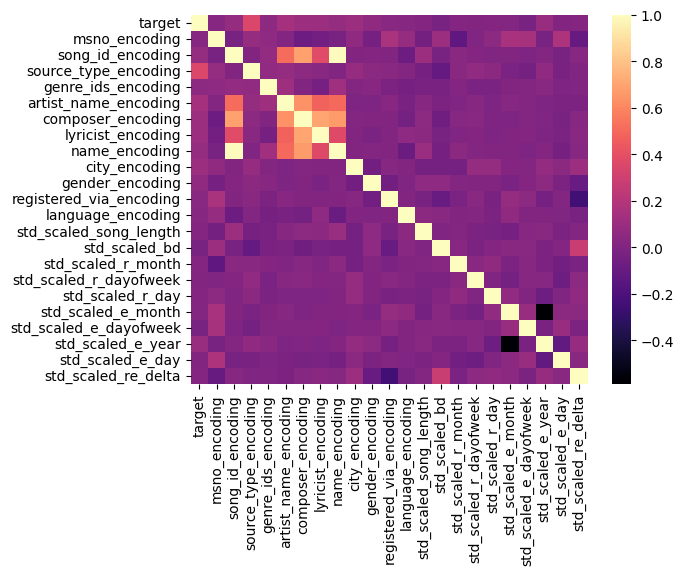

In [ ]:
sns.heatmap(df_prepared.corr(), cmap='magma')

In [ ]:
# Split into training and test datasets

x = df_prepared.drop(['target'], axis=1)
y = df_prepared['target']

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=42)

In [ ]:
# Using the optuna library, we will select the optimal hyperparameters for several models: LGBMClassifier,
# RandomForestClassifier and XGBClassifier
seed = 42
np.random.seed(seed)

def objective(trial,data=x,target=y):

    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.3,random_state=42)
    param = { 'random_state': 42,
              'n_jobs': 5,
              "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
              "max_features": trial.suggest_categorical("max_features", ['sqrt', 'log2', None]),
              "max_depth": trial.suggest_int("max_depth", 1, 1000),
              "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
              "min_samples_leaf": trial.suggest_int("min_samples_split", 1, 20),
              "criterion": trial.suggest_categorical("criterion", ['gini', 'entropy'])
    }
    model = RandomForestClassifier(**param)

    model.fit(train_x,train_y)

    preds = model.predict_proba(test_x)[:, 1]

    roc_auc = roc_auc_score(test_y, preds)

    return roc_auc

In [ ]:
import optuna

# Define the seed value
SEED = 42  # You can use any integer value as the seed

study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
)
study.optimize(objective, n_trials=100, timeout=600)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)


[I 2023-10-03 09:42:04,477] A new study created in memory with name: no-name-8d8c5526-677c-46e7-9571-a6b87fca38f9
[I 2023-10-03 09:42:07,402] Trial 0 finished with value: 0.7570827262425126 and parameters: {'n_estimators': 437, 'max_features': 'sqrt', 'max_depth': 157, 'min_samples_split': 4, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7570827262425126.
[I 2023-10-03 09:42:15,914] Trial 1 finished with value: 0.7536668285575522 and parameters: {'n_estimators': 641, 'max_features': None, 'max_depth': 833, 'min_samples_split': 6, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7570827262425126.
[I 2023-10-03 09:42:17,285] Trial 2 finished with value: 0.7562570827262427 and parameters: {'n_estimators': 374, 'max_features': 'sqrt', 'max_depth': 612, 'min_samples_split': 4, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7570827262425126.
[I 2023-10-03 09:42:19,184] Trial 3 finished with value: 0.7560790027521451 and parameters: {'n_estimators': 510, 'max_features':

Number of finished trials: 100
Best trial: {'n_estimators': 834, 'max_features': 'log2', 'max_depth': 899, 'min_samples_split': 2, 'criterion': 'entropy'}


In [ ]:
def objective(trial,data=x,target=y):

    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.3,random_state=42)
    param = {
             'metric': 'roc_auc',
             'random_state': 42,
             'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
             'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1e2),
             'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1e2),
             'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.6,0.8,1.0]),
             'subsample': trial.suggest_categorical('subsample', [0.6,0.8,1.0]),
             'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
             'learning_rate': trial.suggest_categorical('learning_rate', [0.005,0.01,0.001,0.05]),
             'max_depth': trial.suggest_categorical('max_depth', [10,20, 50, 100]),
             'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
             'min_child_samples': trial.suggest_int('min_child_samples', 1, 300)
    }
    model = LGBMClassifier(**param)

    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],verbose=1)

    preds = model.predict_proba(test_x)[:, 1]

    roc_auc = roc_auc_score(test_y, preds)

    return roc_auc

In [ ]:
import optuna
from lightgbm import LGBMClassifier

def objective(trial, data, target):
    # Define hyperparameters to optimize
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'goss', 'dart']),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'num_leaves': trial.suggest_int('num_leaves', 10, 500),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100)
    }

    # Create and train the model
    model = LGBMClassifier(**param)
    model.fit(train_x, train_y, eval_set=[(test_x, test_y)])

    preds = model.predict_proba(test_x)[:, 1]

    # Calculate a metric for optimization (e.g., AUC)
    auc = roc_auc_score(test_y, preds)

    return auc


In [ ]:
def objective(trial,data=x,target=y):

    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.3,random_state=42)
    param = {
             'random_state': 42,
             'min_child_weight': trial.suggest_int('min_child_weight', 1, 30),
             'gamma': trial.suggest_int('gamma', 1, 1000),
             'subsample': trial.suggest_categorical('subsample', [0.4, 0.6, 0.8, 1.0]),
             'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.4, 0.6, 0.8, 1.0]),
             'max_depth': trial.suggest_categorical('max_depth', [10, 20, 50, 100]),
             'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
             'learning_rate': trial.suggest_categorical('learning_rate', [0.1, 0.01, 0.05, 0.025, 0.001]),
             'tree_method': 'gpu_hist',
             'gpu_id': 0

    }
    model = XGBClassifier(**param)

    model.fit(train_x,train_y)

    preds = model.predict_proba(test_x)[:, 1]

    roc_auc = roc_auc_score(test_y, preds)

    return roc_auc

In [ ]:
import optuna
import xgboost as xgb

def objective(trial, data, target):
    # Define hyperparameters to optimize
    param = {
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'gpu_id': -1  # Use CPU (no GPU)
    }

    # Create and train the model
    model = xgb.XGBClassifier(**param)
    model.fit(train_x, train_y)

    preds = model.predict_proba(test_x)[:, 1]

    # Calculate a metric for optimization (e.g., AUC)
    auc = roc_auc_score(test_y, preds)

    return auc


In [ ]:
# Training models with optimal parameters

rf_clf = RandomForestClassifier(criterion='entropy', n_estimators=641, n_jobs=6, max_depth=833, min_samples_split=6)
XGB = XGBClassifier(colsample_bytree=1.0, gamma=1, gpu_id=0, learning_rate=0.01, max_depth=100,
                    min_child_weight=18, n_estimators=3373, subsample=0.8, tree_method='gpu_hist')
LGBM = LGBMClassifier(boosting_type='gbdt', n_estimators=837, min_child_samples=1, learning_rate=0.05,
                      reg_alpha=0.0254, reg_lambda=1.8398, colsample_bytree=0.8, subsample=0.8, max_depth=50, num_leaves=762)

In [ ]:
import xgboost as xgb

XGB = xgb.XGBClassifier(tree_method='exact')  # or tree_method='hist'

result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for model in [LGBM, rf_clf, XGB]:
    train_model = model.fit(train_x, train_y)
    y_proba = train_model.predict_proba(test_x)[:,1]
    y_pred = train_model.predict(test_x)

    accuracy = accuracy_score(test_y, y_pred)
    roc_auc = roc_auc_score(test_y, y_proba)
    print('Metrics values on test sample:')
    print(f'Model {(str(model).split("(")[0])}:\nROC_AUC - {round(roc_auc, 2)}\
          \nAccuracy - {round(accuracy, 2)}\n{"-" * 40}')

    fpr, tpr, _ = roc_curve(test_y,  y_proba)

    result_table = result_table.append({'classifiers':model.__class__.__name__,
                                        'fpr':fpr,
                                        'tpr':tpr,
                                        'auc':roc_auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

[LightGBM] [Info] Number of positive: 1057, number of negative: 287
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1012
[LightGBM] [Info] Number of data points in the train set: 1344, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.786458 -> initscore=1.303708
[LightGBM] [Info] Start training from score 1.303708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

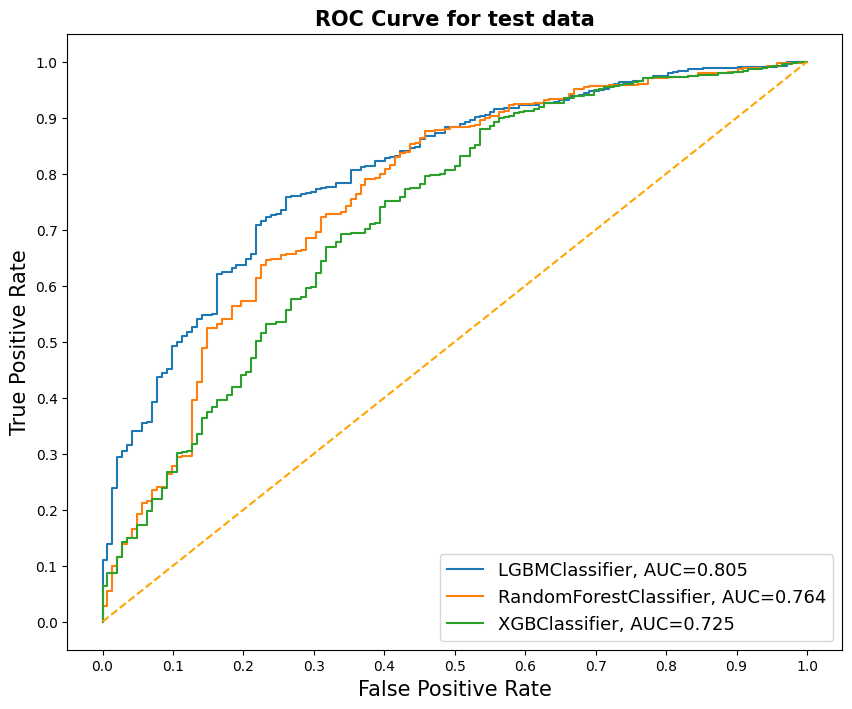

In [ ]:
# Plotting ROC_AUC for models on test set

fig = plt.figure(figsize=(10,8))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'],
             result_table.loc[i]['tpr'],
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))

plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve for test data', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show();

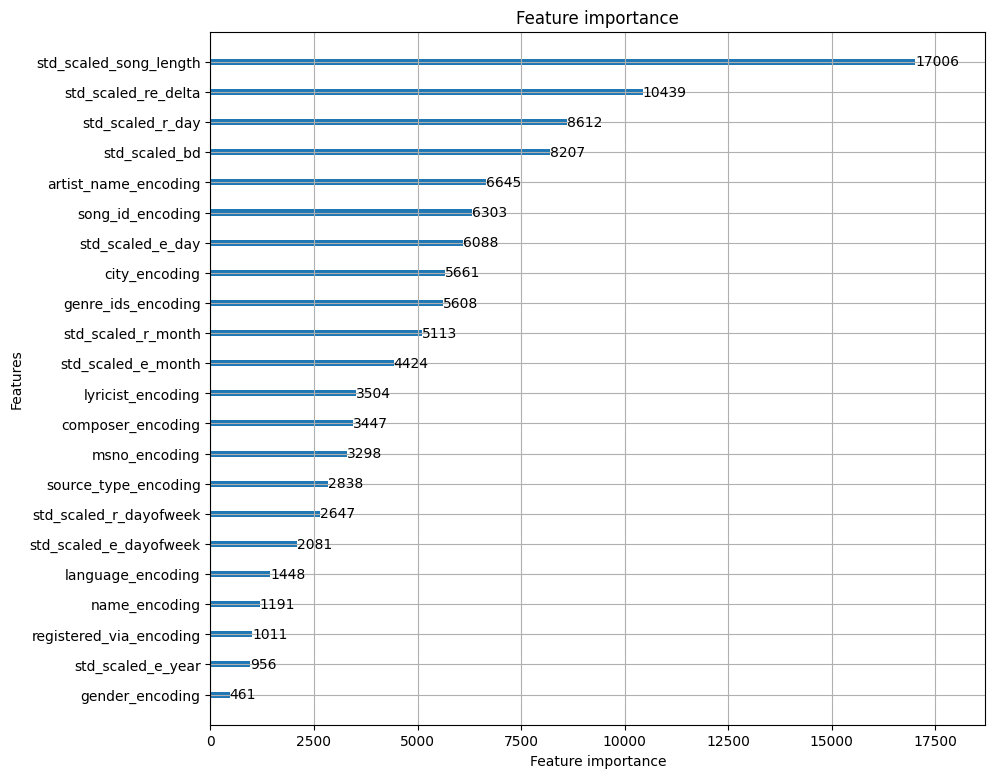

In [ ]:
# feature_importances for a LGBMClassifier model

plot_importance(LGBM, figsize=(10, 9));

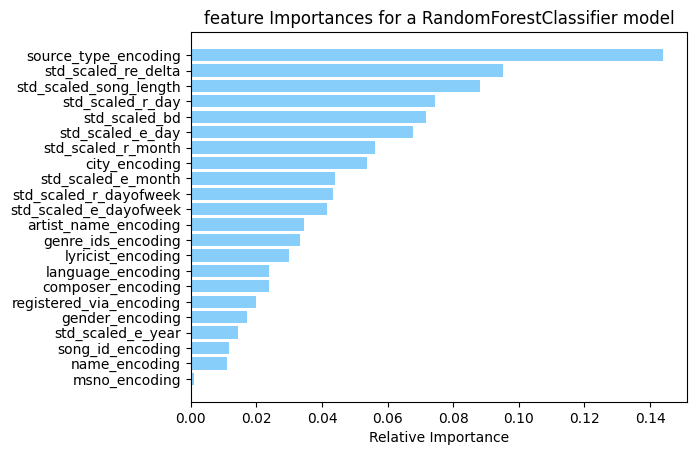

In [ ]:
# feature_importances for a RandomForestClassifier model

feat_dict = dict(zip(rf_clf.feature_names_in_, rf_clf.feature_importances_))
sorted_feat_dict = {}
sorted_keys = sorted(feat_dict, key=feat_dict.get)  # [1, 3, 2]

for w in sorted_keys:
    sorted_feat_dict[w] = feat_dict[w]

plt.title('feature Importances for a RandomForestClassifier model')
plt.barh(list(sorted_feat_dict.keys()), list(sorted_feat_dict.values()), color='lightskyblue', align='center')
plt.yticks(list(sorted_feat_dict.keys()))
plt.xlabel('Relative Importance')
plt.show();

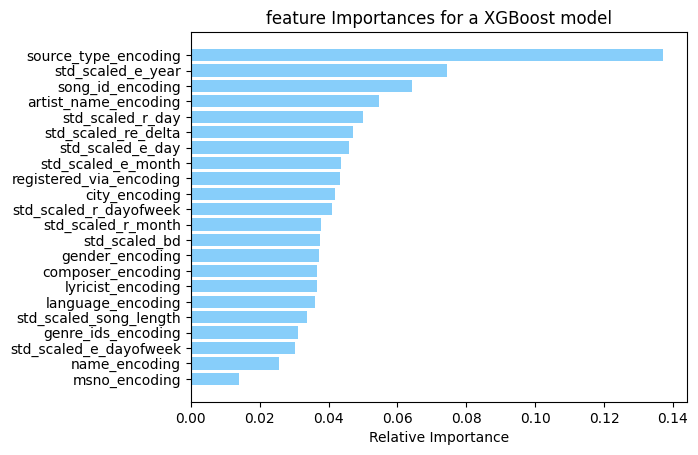

In [ ]:
# feature_importances for a XGBoost model

feature_names = XGB.get_booster().feature_names

feat_dict = dict(zip(feature_names, XGB.feature_importances_))
sorted_feat_dict = {}
sorted_keys = sorted(feat_dict, key=feat_dict.get)  # [1, 3, 2]

for w in sorted_keys:
    sorted_feat_dict[w] = feat_dict[w]

plt.title('feature Importances for a XGBoost model')
plt.barh(list(sorted_feat_dict.keys()), list(sorted_feat_dict.values()), color='lightskyblue', align='center')
plt.yticks(list(sorted_feat_dict.keys()))
plt.xlabel('Relative Importance')
plt.show();